# Linear Regression
## November 8th, 2022
### Overview: Use Linear Regression for classification

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd
import time
import scipy.linalg as la
import statsmodels.api as sm
from sklearn import linear_model
from itertools import combinations
from matplotlib import pyplot as plt

#### OLS
A function that takes as input $X$ and **y** and returns the least squares estimator for $\beta$ as a numpy array.

In [2]:
def ols(X, y):
    """
    Solves for the least squares estimator.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpyarray
    """
    #get shape of X (even if 1d)
    if len(X.shape) == 1:
        n, d = X.shape[0],1
    else: n, d = X.shape
    
    
    #add column of ones on the left
    X_ = np.hstack((np.ones(n).reshape(-1,1),X.reshape(n,d)))
    
    #calculate beta
    B = (np.linalg.inv(X_.T@X_))@X_.T@y
    return B

#### Visual Demonstration 1
Finding the least squares estimator for $\beta$ on random data, and showing the random data and the line of best fit determined by the least squares estimator for $\beta$. 

In [3]:
#generating random data
n = 100 # Number of points to generate
X = np.arange(100) # The input X for the function ols
eps = np.random.uniform(-10,10, size=(100,)) # Noise to generate random y coordinates
y = .3*X + 3 + eps # The input y for the function ols

#finding beta
B = ols(X,y)

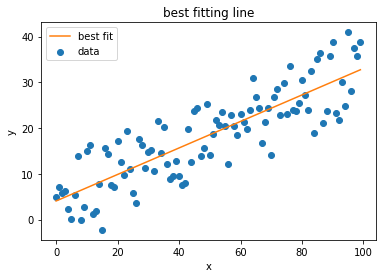

In [4]:
#plot points and best fit
plt.scatter(X,y,label='data')
plt.plot(X,B[1]*X+B[0],color='tab:orange',label='best fit')
plt.xlabel('x')
plt.ylabel('y')
plt.title('best fitting line')
plt.legend()
plt.show()

#### SVD OLS 
In the case that the X.T@X is singular, the least squares estimator is calculated using the SVD. 

In [5]:
def svd_ols(X, y):
    """
    Solves for the least squares estimator using the SVD.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpy array
    """
    #find shape of x (even if 1d)
    if len(X.shape) == 1:
        n, d = X.shape[0],1
    else: n, d = X.shape
    
    #stack on with column of  ones
    X_ = np.hstack((np.ones(n).reshape(n,-1),X.reshape(n,d)))
    
    #svd
    U,E,VH = la.svd(X_,full_matrices=False)
    
    #calculate beta
    B = VH.T@np.diag(1/E)@U.T@y
    return B

#### Visual Demonstration 2
Using **svd_ols** to find the least squares estimator for a cubic polynomial. Showing the data and best fitting curve.

In [6]:
#generating random cubic data
x = np.linspace(-4, 2, 500)
y = x**3 + 3*x**2 - x - 3.5
eps = np.random.normal(0, 3, len(y)) # Create noise
y += eps # Add noise to randomize data

#use vandermonde matrix to allow for cubic
X = np.vander(x,4,increasing=True)
#solve for beta
B = svd_ols(X[:,1:],y)

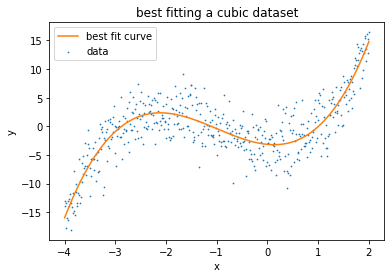

In [7]:
#plot problem above
plt.scatter(x,y,s=0.5,label='data')
plt.plot(x,X@B,color='tab:orange',label='best fit curve')
plt.xlabel('x')
plt.ylabel('y')
plt.title('best fitting a cubic dataset')
plt.legend()
plt.show()

#### Implementation on real data
The file **realestate.csv** contains transaction data from 2012-2013. 
It has columns for transaction data, house age, distance to nearest MRT station, number of convenience stores, latitude, longitude, and house price of unit area.
Each row in the array is a separate measurement.

Finding the combination of variables that builds the model with the best $R^2$ value when predicting **house price of unit area**. Using **statsmodels** to build each model and calculate $R^2$. Using the same combination of variables, timing the methods **ols**, **svd_ols**, and **statsmodels** . Returning a list with the first element being a tuple of times for each method and the second element being the best $R^2$ value from the first part of this implementation.

In [10]:
def housing_implementation():
    """
    Find the best R2 value using statsmodels.
    Then time ols, svd_ols, and statsmodlels.
    Returns:
        list(): a tuple of times and the best R2 value
    """
    #read in file, isolate the dependent column
    real = pd.read_csv('realestate.csv',index_col=0)
    y = real['Y house price of unit area']
    
    #list to hold r2 values and combos
    r2s = []
    combos = []
    #init lists to record times
    ols_times = []
    svd_times = []
    stats_times=[]
    
    #try every combo
    for n in range(1,7):
        for combo in combinations(real.columns[:-1],n):
            #make data from the combo
            x = real[[col for col in combo]]
            X = sm.add_constant(x)
            
            #time ols
            start = time.time()
            ols(x.values,y.values)
            ols_times.append(time.time()-start)
            
            #time svd
            start = time.time()
            svd_ols(x.values,y.values)
            svd_times.append(time.time()-start)
            
            #time stats models
            start = time.time()
            model = sm.OLS(y, X).fit()
            stats_times.append(time.time()-start)
            
            #find and append r squared values, also append combo
            r2s.append(model.rsquared)
            combos.append(combo)
            
    #find r2 value and corresponding combo
    bestind = np.argmax(r2s)
    best_combo = combos[bestind]
    
    return [(ols_times[bestind], svd_times[bestind], stats_times[bestind]),max(r2s)]

In [11]:
housing_implementation()

[(0.00017905235290527344, 0.0001773834228515625, 0.0004911422729492188),
 0.5823704472723096]

## Implementation 2
Using the file **realestate.csv**, calculating model AIC and BIC. 
For the dependent variable, using **house price of unit area**. 
For the independent variables, using **distance to the nearest MRT station**, **number of convenience stores**, **latitude**, and **longitude**.

Finding the model that has the lowest AIC and the model that has the lowest BIC. 

In [12]:
#read in file, set dependent value
real = pd.read_csv('realestate.csv',index_col=0)
y = real['Y house price of unit area']

#init lists to hold values and combos
aics = []
bics = []
combos=[]

#for all combinations
for n in range(1,5):
    for combo in combinations(real.columns[2:6],n):
        #create independent values
        x = real[[col for col in combo]]
        X = sm.add_constant(x)
        
        #fit model, find and append values and combo
        model = sm.OLS(y, X).fit() 
        aics.append(model.aic)
        bics.append(model.bic)
        combos.append(combo)

In [13]:
#find indices of best aic and bic
aic_ind = np.argmin(aics)
bic_ind = np.argmin(bics)
print('best aic is,', min(aics),'with combo',combos[aic_ind])
print('best bic is',min(bics),'with combo',combos[bic_ind])
print('These variable combinations are the same for the best AIC and best BIC')

best aic is, 3038.536259321836 with combo ('X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude')
best bic is 3054.639723217137 with combo ('X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude')
These variable combinations are the same for the best AIC and best BIC


#### SKLearn Implementation
Using Ridge and Lasso Regression to model **house price of unit area** from the file **realestate.csv**.
Before fitting each model, running a GridSearch on $\alpha$ to find the optimal value.
Then using the optimal $\alpha$ to fit the model.
Once the model has been fit, using the **score** method to get $R^2$. 
Printing $R^2$ for each model as a tuple. 

In [14]:
#read in file, set dependent and independent values
real = pd.read_csv('realestate.csv',index_col=0)
y = real['Y house price of unit area']
X = real[real.columns[:-1]]

#fit and score ridge, print results
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y) # Fit the model
print('best ridge alpha:',reg.alpha_) # Best parameter value
print('ridge score:',reg.score(X,y),'\n')

#fit and score lasso, print results
lass = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
lass.fit(X, y) # Fit the model
print('best lasso alpha:',lass.alpha_) # Best parameter value
print('lasso score:',lass.score(X,y))

best ridge alpha: 0.001
ridge score: 0.5823545946205277 

best lasso alpha: 0.001
lasso score: 0.5822617746792913
